<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=150 style="padding: 5px">
<img align="left" src=https://noirlab.edu/public/media/archives/images/screen640/ann22016a.jpg width=200 style="padding: 5px">
<br>

<b>What's That Streak?</b><br>
A Rubin x SatHub notebook by Meredith Rawls<br>
Last verified to run: June 17, 2025<br>
LSST Science Pipelines version: w_2025_24<br>

### Edit this top cell with the Rubin visit of interest, and run the notebook

The parameter `obsinfo` is a visit ID, which may typically constructed as date_obs + 00 + seq_num.

Only one cell below uses the Butler, which is instantiated via `repo`, `collections`, and `instrument`. Use a default collection that includes the desired visit, and ideally a `preliminary_visit_summary` data product (this is used to draw the camera footprint on the sky). The Butler is only used to retrieve basic information about where in the sky the telescope was pointing, and when, which is pipeline-agnostic.

In [1]:
obsinfo = 2025050100254

# LSSTCam
repo = 'embargo'
collections = ['LSSTCam/runs/nightlyValidation']
instrument = 'LSSTCam'

# LSSTComCam
#repo = '/repo/dp1'
#collections = ['LSSTComCam/DP1']
#instrument = 'LSSTComCam'

### You shouldn't need to change anything below, it should "just work"

The SatChecker query includes a generous 3 degree radius FOV and a generous duration 3x the exposure time (centered on the exposure midpoint).

To learn more about SatChecker, please visit https://satchecker.readthedocs.io

In [2]:
%matplotlib widget

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, EarthLocation
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import lsst.daf.butler as dafButler
from lsst.obs.lsst import LsstCam

In [4]:
fov_radius = 3  # FOV query radius, in degrees
# Note LSSTComCam is about 0.67 deg across on the sky ... LSSTCam FOV has a radius of 1.76 deg

In [5]:
location=EarthLocation.of_site('Rubin')
latitude = location.lat.value  # deg
longitude = location.lon.value  # deg
elevation = location.height.value  # meters

In [6]:
butler = dafButler.Butler(repo, collections=collections, instrument=instrument)
camera = LsstCam().getCamera()
detectors = [det.getId() for det in camera]
visit_record = butler.query_dimension_records("visit", instrument="LSSTCam", visit=obsinfo)[0]
cornersList = []
try:
    pvs = butler.get('preliminary_visit_summary', visit=obsinfo)

except dafButler.DatasetNotFoundError:
    print('No preliminary_visit_summary found, using summaryStats instead (slower)')
    for detector in detectors:
        try:
            summaryStats = butler.get('preliminary_visit_image.summaryStats', visit=obsinfo, detector=detector)
        except dafButler.DatasetNotFoundError:
            print(f'No summaryStats available for detector {detector}')
            cornersList.append([(None, None), (None, None), (None, None), (None, None)])
            continue
        else:
            cornersList.append(list(zip(summaryStats.raCorners, summaryStats.decCorners)))
else:
    for row in pvs:
        cornersList.append(list(zip(row["raCorners"], row["decCorners"])))

In [7]:
exp_time = visit_record.exposure_time*u.s
exp_begin = visit_record.timespan.begin

# the query time window will go from T0 - Texp to T0 + 2*Texp, for a total duration of 3*Texp
start_time_jd = (exp_begin - exp_time).jd
duration = (exp_time * 3).value

In [8]:
coord = SkyCoord(alt=90*u.deg - visit_record.zenith_angle*u.deg,
                az=visit_record.azimuth*u.deg,
                obstime=exp_begin + (exp_time/2),
                location=EarthLocation.of_site('Rubin'),
                frame = 'altaz')
ra_center = coord.icrs.ra.value  # deg
dec_center = coord.icrs.dec.value  # deg

In [9]:
# Make the SatChecker API request
url_string = f"https://dev.satchecker.cps.iau.noirlab.edu/fov/satellite-passes/?latitude={latitude}&longitude={longitude}&elevation={elevation}&start_time_jd={start_time_jd}&duration={duration}&ra={ra_center}&dec={dec_center}&fov_radius={fov_radius}&group_by=satellite"
response = requests.get(url_string, timeout=60)
data = response.json()
print(url_string)

https://dev.satchecker.cps.iau.noirlab.edu/fov/satellite-passes/?latitude=-30.244633333333333&longitude=-70.74941666666666&elevation=2662.7500000010978&start_time_jd=2460797.522259277&duration=90.0&ra=187.59777398769648&dec=8.390978858729897&fov_radius=3&group_by=satellite


In [10]:
# Extract RA/Dec positions for each satellite
satellites = {}

for sat_key, sat_data in data['data']['satellites'].items():
    if sat_key not in satellites:
        satellites[sat_key] = []
    # Add ra, dec, and julian_date from each position
    for position in sat_data['positions']:
        satellites[sat_key].append([
            position['ra'],
            position['dec'],
            position['julian_date']
        ])

print(f"Public catalog satellites passing through the specified FOV, as seen from Rubin Observatory, starting at {start_time_jd} JD for {duration} seconds:")
for sat in satellites:
    print(f"{sat}: {len(satellites[sat])} points")

Public catalog satellites passing through the specified FOV, as seen from Rubin Observatory, starting at 2460797.522259277 JD for 90.0 seconds:
ATLAS 5 CENTAUR DEB (43988): 76 points
BLOCK DM-SL R/B (29350): 90 points
DELTA 1 R/B(2) (17563): 90 points
DIRECTV 6 (TEMPO 2) (24748): 90 points
EUTE 12 WEST B (26927): 90 points
SL-6 R/B(2) (11888): 90 points
STARLINK-5156 (53973): 16 points
USA 113 (23628): 90 points


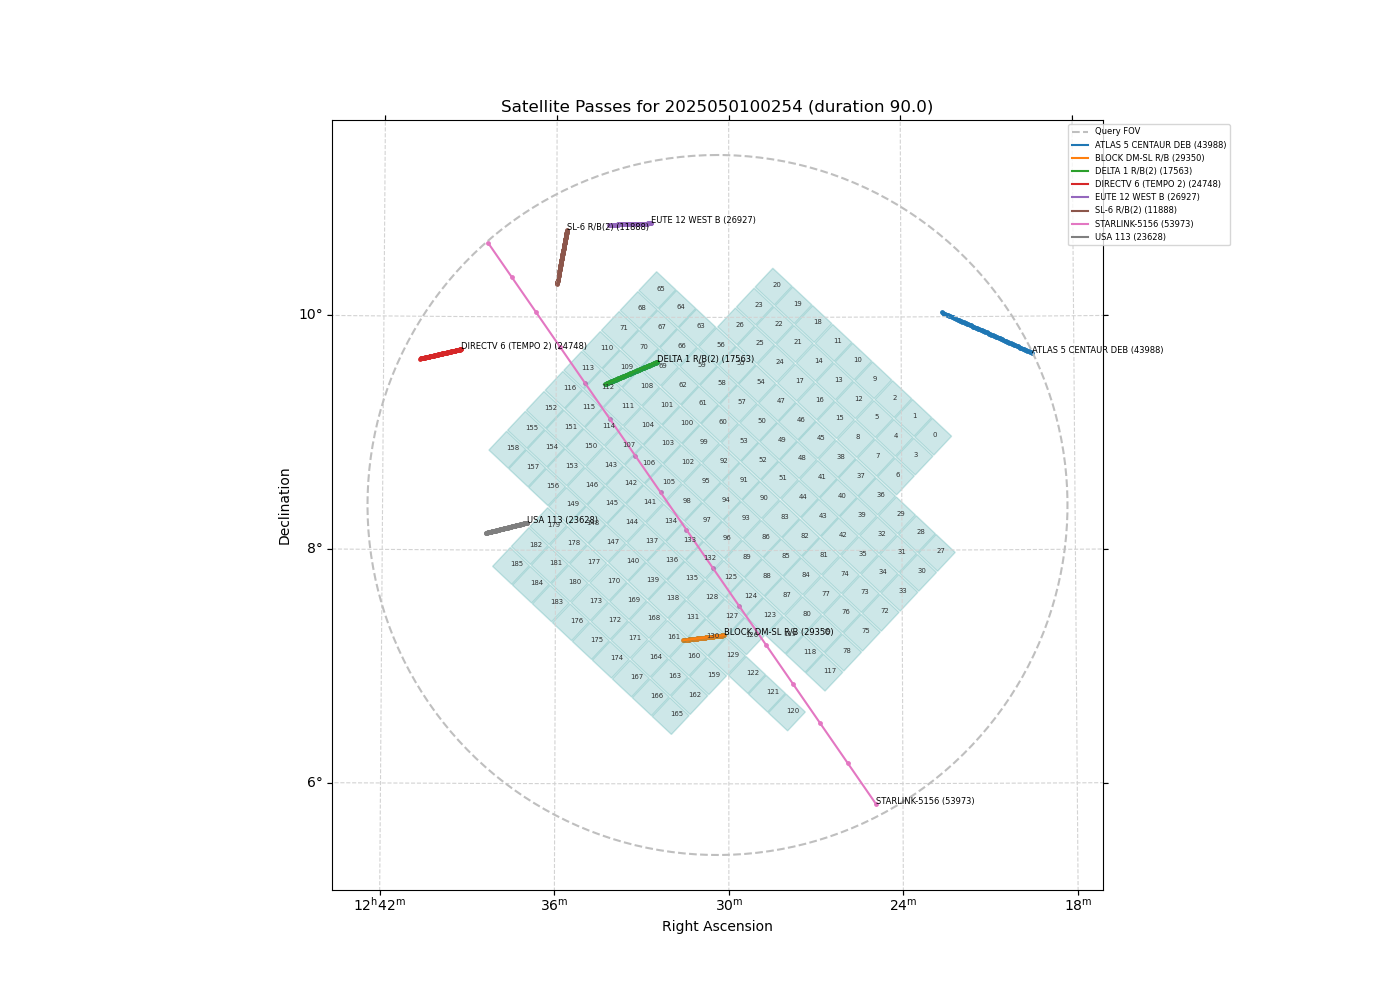

In [11]:
# Simple WCS for the plot
wcs = WCS(naxis=2)
wcs.wcs.crpix = [0, 0]
wcs.wcs.crval = [ra_center, dec_center]
wcs.wcs.cdelt = [0.1, 0.1]
wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg, frame='icrs')
position_angles = np.linspace(0, 360, 360) * u.deg
circle_points = center.directional_offset_by(position_angles, fov_radius * u.deg)

# Query FOV
ax.plot(circle_points.ra.deg, circle_points.dec.deg, 
        c='0.75', ls='--', label='Query FOV', transform=ax.get_transform('world'))

# Satellite tracks
for sat_name in satellites.keys():
    ra = [pos[0] for pos in satellites[sat_name]]
    dec = [pos[1] for pos in satellites[sat_name]]
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    
    # Satellite track
    ax.plot(coords.ra.deg, coords.dec.deg, 
            transform=ax.get_transform('world'),
            label=sat_name)
        
    # Satellite position points
    ax.scatter(coords.ra.deg, coords.dec.deg, 
               transform=ax.get_transform('world'), s=6)
    
    # Start and end labels
    times = [pos[2] for pos in satellites[sat_name]]
    if coords.ra.deg[0] < coords.ra.deg[-1]:
        ax.text(coords.ra.deg[0], coords.dec.deg[0], f'{sat_name}', 
                transform=ax.get_transform('world'), fontsize="6")  
    else:
        ax.text(coords.ra.deg[-1], coords.dec.deg[-1], f'{sat_name}', 
            transform=ax.get_transform('world'), fontsize="6")

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left', fontsize="6")
ax.set_xlabel('Right Ascension')
ax.invert_xaxis()
ax.set_ylabel('Declination')
ax.set_title(f'Satellite Passes for {obsinfo} (duration {duration:.1f})')
ax.grid(color='lightgray', linestyle='--')

# Draw the camera on the sky, and label the detectors
for idx, corners in enumerate(cornersList):
    poly = Polygon(
        corners, 
        closed=True, 
        color="#058B8C",
        alpha=0.2,
        transform=ax.get_transform('world')
    )
    try:
        ax.add_patch(poly)
    except AttributeError:  # the corners list is not available
        continue
    else:
        ax.text(
            corners[1][0], corners[2][1], detectors[idx], 
            transform=ax.get_transform("world"),
            fontsize=5,
            color='#313333'
        )
    
# Option: plot a circle representing the LSSTCam FOV instead
#rubin_fov_radius = 1.761111
#rubin_circle_points = center.directional_offset_by(position_angles, rubin_fov_radius * u.deg)
#ax.plot(rubin_circle_points.ra.deg, rubin_circle_points.dec.deg,
#        c='0.75', ls=':', label='LSSTCam FOV', transform=ax.get_transform('world'))